## CASIMAC Demo

In [5]:
from casimac import CASIMAClassifier

### 1. Binary classification

In [6]:
# Create data

import numpy as np

N = 10
seed = 42
X = np.random.RandomState(seed).uniform(-10,10,N).reshape(-1,1)
y = np.zeros(X.size)
y[X[:,0]>0] = 1

In [7]:
# Classify

from sklearn.gaussian_process import GaussianProcessRegressor
clf = CASIMAClassifier(GaussianProcessRegressor)
clf = clf.fit(X, y)

In [8]:
# Predict

X_sample = np.linspace(-10,10,100).reshape(-1,1)
y_sample = clf.predict(X_sample)
p_sample = clf.predict_proba(X_sample)
d_sample = clf.decision_function(X_sample)

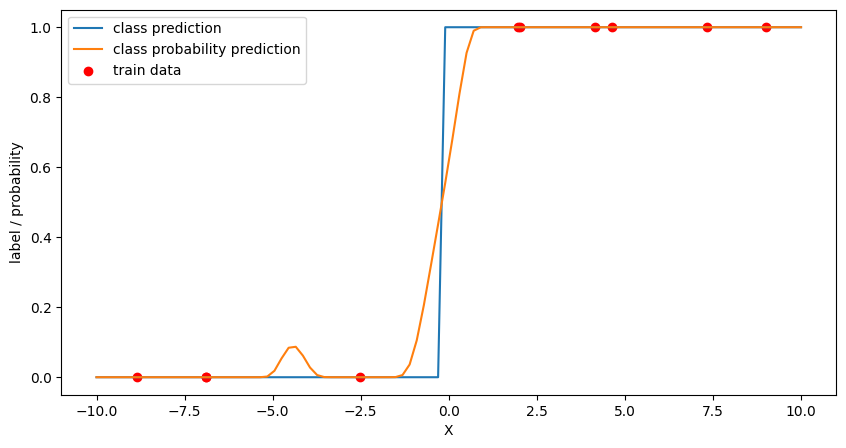

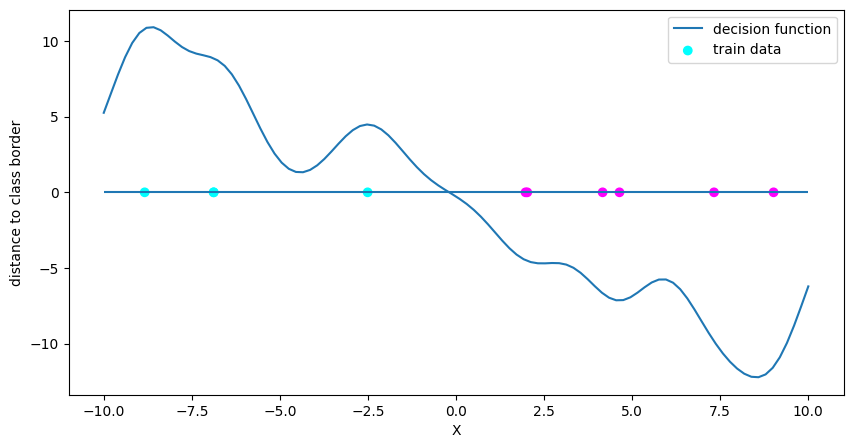

In [9]:
# Plot results

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(X_sample,y_sample,label="class prediction")
plt.plot(X_sample,p_sample[:,1],label="class probability prediction")
plt.scatter(X,y,c='r',label="train data")
plt.xlabel("X")
plt.ylabel("label / probability")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.hlines(0,-10,10)
plt.plot(X_sample,d_sample,label="decision function")
plt.scatter(X,0*y,c=y,label="train data", cmap="cool")
plt.xlabel("X")
plt.ylabel("distance to class border")
plt.legend()
plt.show()

### 2. Multi-class classification

In [10]:
# Create data

import numpy as np

N = 10
seed = 42
X = np.random.RandomState(seed).uniform(-10,10,N).reshape(-1,1)
y = np.zeros(X.size)
y[X[:,0]>5] = 1
y[X[:,0]<-5] = 2

In [11]:
# Classify

from sklearn.gaussian_process import GaussianProcessRegressor
clf = CASIMAClassifier(GaussianProcessRegressor, proba_calc_method="MC")
clf = clf.fit(X, y)

In [12]:
# Predict

X_sample = np.linspace(-10,10,100).reshape(-1,1)
y_sample = clf.predict(X_sample)
p_sample = clf.predict_proba(X_sample)
d_sample, idx_col_map = clf.decision_function(X_sample, return_idx_col_map=True)

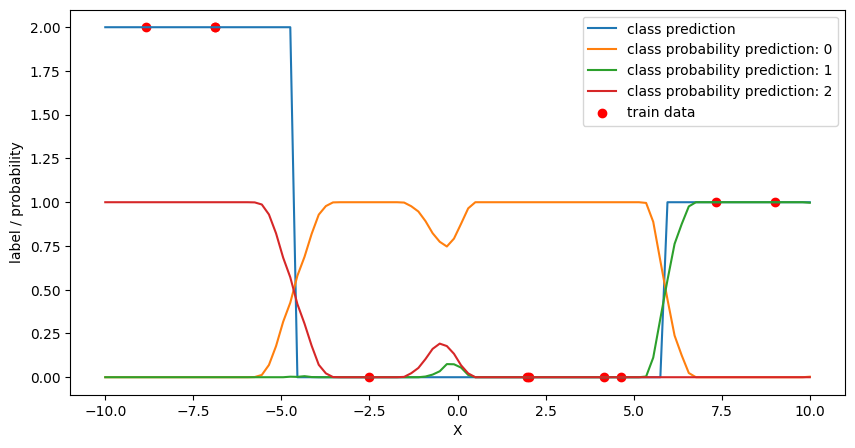

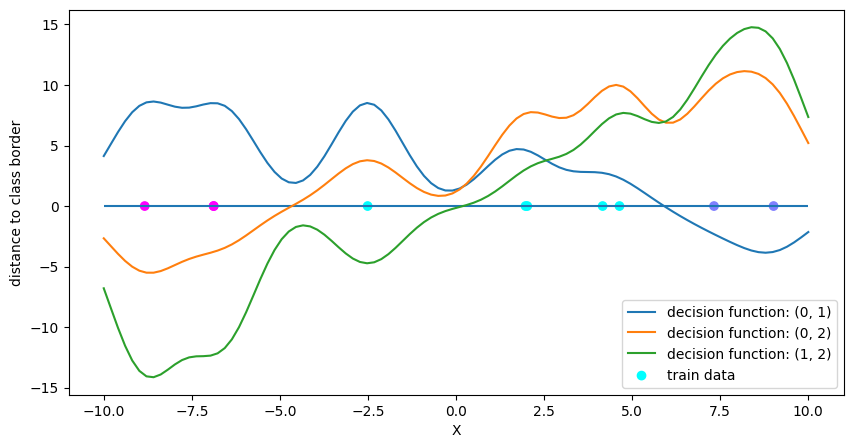

In [13]:
# Plot results

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(X_sample,y_sample,label="class prediction")
plt.plot(X_sample,p_sample[:,0],label="class probability prediction: 0")
plt.plot(X_sample,p_sample[:,1],label="class probability prediction: 1")
plt.plot(X_sample,p_sample[:,2],label="class probability prediction: 2")
plt.scatter(X,y,c='r',label="train data")
plt.xlabel("X")
plt.ylabel("label / probability")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.hlines(0,-10,10)
plt.plot(X_sample,d_sample[:,0],label="decision function: {}".format(idx_col_map[0]))
plt.plot(X_sample,d_sample[:,1],label="decision function: {}".format(idx_col_map[1]))
plt.plot(X_sample,d_sample[:,2],label="decision function: {}".format(idx_col_map[2]))
plt.scatter(X,0*y,c=y,label="train data", cmap="cool")
plt.xlabel("X")
plt.ylabel("distance to class border")
plt.legend()
plt.show()

### 3. Gradients

In [14]:
# Create data

import numpy as np

N = 10
seed = 42
X = np.random.RandomState(seed).uniform(-10,10,N).reshape(-1,1)
y = np.zeros(X.size)
y[X[:,0]>0] = 1

In [15]:
# Classify

import GPy
np.bool = bool # workaround for legacy error in GPy
class GPRegressor:
    def __init__(self, kernel):
        self.kernel = kernel
      
    def fit(self, X, y):
        self._models = []
        for i in range(y.shape[1]):
            model = GPy.models.GPRegression(X, y[:,i].reshape(-1,1), self.kernel)
            model.optimize_restarts(verbose=False) 
            self._models.append(model)
    
    def predict(self, X, return_std=False):
        mean, var = np.empty((X.shape[0],0)), np.empty((X.shape[0],0))
        for model in self._models:
            mean_part, var_part = model.predict(X, full_cov=False) # part_var: only diagonal
            mean = np.append(mean,mean_part,axis=1)
            var = np.append(var,var_part,axis=1)
        mean, var = np.array(mean), np.array(var) # mean: [n_samples, n_outputs], var: [n_samples, n_outputs]
        var = np.clip(var, 0, np.inf)
        if return_std:
            return mean, np.sqrt(var)
        else:
            return mean
        
    def predict_grad(self, X, return_std=False):
        dmean, dvar = np.empty((X.shape[0],X.shape[1],0)), np.empty((X.shape[0],X.shape[1],0))
        for model in self._models:
            dmean_part, dvar_part = model.predictive_gradients(X)
            dmean = np.append(dmean,dmean_part,axis=2)
            dvar = np.append(dvar,dvar_part[:,:,np.newaxis],axis=2)
        dmean, dvar = np.array(dmean), np.array(dvar) # dmean: [n_sample, n_vars, n_output], dvar: [n_sample, n_vars, n_output]
        if return_std:
            _, std = self.predict(X, return_std=True)
            std[std==0] = np.nan
            dstd = dvar/(2*std[:,np.newaxis,:])
            dstd[np.isnan(dstd)] = np.inf
            return dmean, dstd
        else:
            return dmean
        
clf = CASIMAClassifier(lambda:GPRegressor(GPy.kern.RBF(input_dim=X.shape[1], variance=1, lengthscale=1)))
clf = clf.fit(X, y)

In [16]:
# Predict

X_sample = np.linspace(-10,10,250).reshape(-1,1)
y_sample = clf.predict(X_sample)
p_sample = clf.predict_proba(X_sample)
d_sample = clf.decision_function(X_sample)

In [17]:
# Prediction gradients

dp_sample = clf.predict_proba_grad(X_sample)
dd_sample = clf.decision_function_grad(X_sample)

In [18]:
# Gradient errors

from scipy.optimize import check_grad

dp_errors = []
for x0 in X_sample:
    dp_errors.append(check_grad(lambda X:clf.predict_proba(X.reshape(1,-1))[:,1], lambda X:clf.predict_proba_grad(X.reshape(1,-1))[:,0,1], x0))   
dp_errors = np.array(dp_errors)
dd_errors = []
for x0 in X_sample:
    dd_errors.append(check_grad(lambda X:clf.decision_function(X.reshape(1,-1)), lambda X:clf.decision_function_grad(X.reshape(1,-1)).ravel(), x0))
dd_errors = np.array(dd_errors)

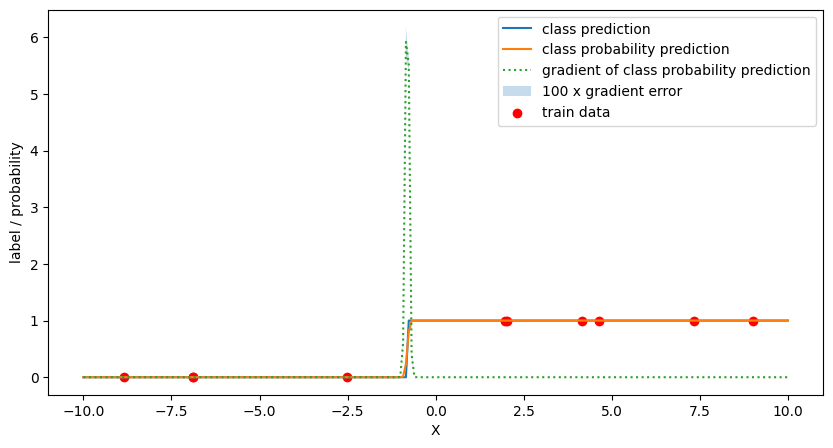

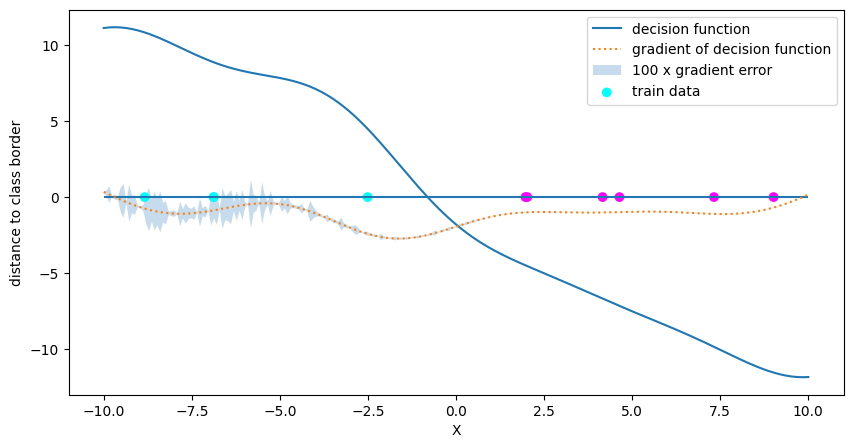

In [19]:
# Plot results

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(X_sample,y_sample,label="class prediction")
plt.plot(X_sample,p_sample[:,1],label="class probability prediction")
plt.plot(X_sample,dp_sample[:,0,1],":",label="gradient of class probability prediction")
plt.fill_between(X_sample.ravel(),dp_sample[:,0,1]-100*dp_errors,dp_sample[:,0,1]+100*dp_errors,alpha=.25,label="100 x gradient error")
plt.scatter(X,y,c='r',label="train data")
plt.xlabel("X")
plt.ylabel("label / probability")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.hlines(0,-10,10)
plt.plot(X_sample,d_sample,label="decision function")
plt.plot(X_sample,dd_sample,":",label="gradient of decision function")
plt.fill_between(X_sample.ravel(),dd_sample.ravel()-100*dd_errors,dd_sample.ravel()+100*dd_errors,alpha=.25,label="100 x gradient error")
plt.scatter(X,0*y,c=y,label="train data", cmap="cool")
plt.xlabel("X")
plt.ylabel("distance to class border")
plt.legend()
plt.show()

### 4. Visualization

In [20]:
# Create data

from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [21]:
# Classify

from sklearn.gaussian_process import GaussianProcessRegressor
clf = CASIMAClassifier(GaussianProcessRegressor, proba_calc_method="MC")
clf = clf.fit(X, y)

In [22]:
# Transform

tau = .4
s_r = clf.transform(clf.d_, tau=tau, method='reference')
s_s = clf.transform(clf.d_, tau=tau, method='scale')

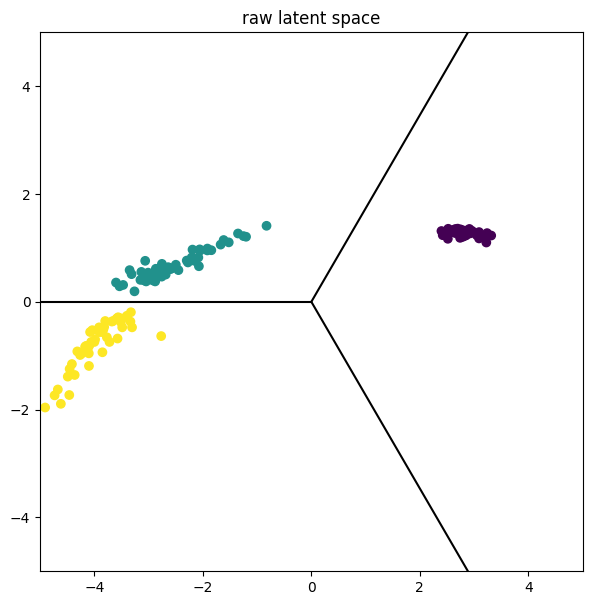

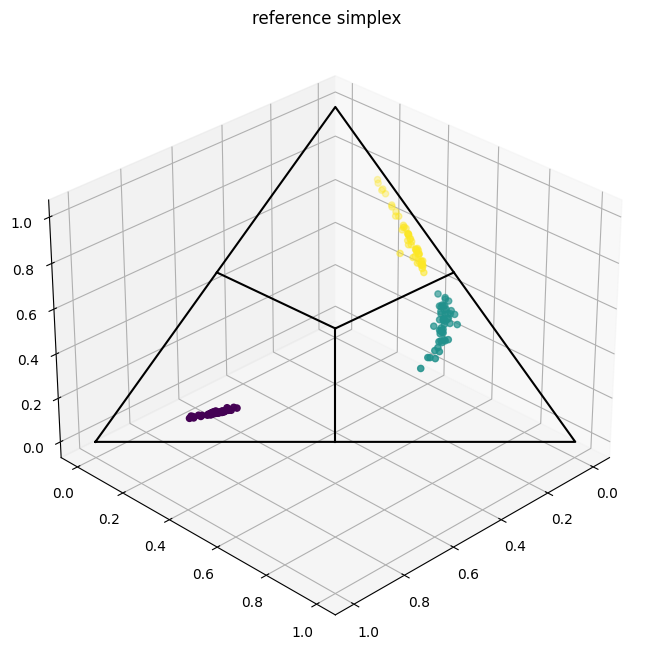

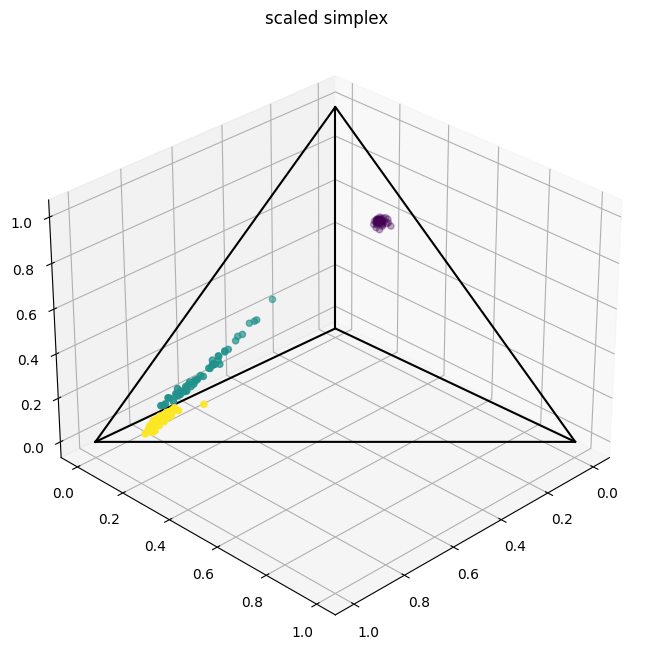

In [23]:
# Plot results

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7,7))
plt.scatter(clf.d_[:,0], clf.d_[:,1], c=y)
plt.plot([0,-10*clf._class_normals[0,0]], [0,-10*clf._class_normals[0,1]], 'k')
plt.plot([0,-10*clf._class_normals[1,0]], [0,-10*clf._class_normals[1,1]], 'k')
plt.plot([0,-10*clf._class_normals[2,0]], [0,-10*clf._class_normals[2,1]], 'k')
plt.title('raw latent space')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot([1,0,0,1], [0,1,0,0], [0,0,1,0], 'k')
ax.plot([1/3,.5], [1/3,.5], [1/3,0], 'k')
ax.plot([1/3,0], [1/3,.5], [1/3,.5], 'k')
ax.plot([1/3,.5], [1/3,0], [1/3,.5], 'k')
ax.scatter(s_r[:,0], s_r[:,1], s_r[:,2], c=y)
plt.title('reference simplex')
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot([1,0,0,1], [0,1,0,0], [0,0,1,0], 'k')
ax.plot([1/3,1], [1/3,0], [1/3,0], 'k')
ax.plot([1/3,0], [1/3,1], [1/3,0], 'k')
ax.plot([1/3,0], [1/3,0], [1/3,1], 'k')
ax.scatter(s_s[:,0], s_s[:,1], s_s[:,2], c=y)
plt.title('scaled simplex')
plt.show()

In [24]:
# Inverse Transform
import numpy as np

e_r = np.linalg.norm(clf.d_ - clf.inverse_transform(s_r, tau=tau, method='reference'))
e_s = np.linalg.norm(clf.d_ - clf.inverse_transform(s_s, tau=tau, method='scale'))

print(f'Transformation error (distance norm) for reference transformation: {e_r}')
print(f'Transformation error (distance norm) for scale transformation:     {e_s}')

Transformation error (distance norm) for reference transformation: 6.755104984998801e-15
Transformation error (distance norm) for scale transformation:     7.473675149959263e-15
